# Borders, Obstacles & Buffering

This notebook shows how *OptiWindNet* models spatial constraints for wind-farm layout and cabling. We will initialize networks with different combination of exterior borders and interior obstacles. We will also explore buffering—expanding borders and shrinking obstacles; to see how it can remove concavities, split or eliminate obstacles, and trigger informative warnings when shapes intersect or turbines fall outside permitted areas.


Import required packages

In [1]:
from optiwindnet.api import WindFarmNetwork
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Borders and obstacles

Define Cordinates (Turbines, substations, borders, and obstacles).

In [3]:
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)
substationsC = np.array([[696, 1063],], dtype=float)
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)
obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
]

### 1. Initialize and optimize wfn with the defined coordinates.

In [4]:
wfn1 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC, buffer_dist=1)
res_optimize = wfn1.optimize()

[[ 696. 1063.]]


Plot Navigation meth, available links, selected links, and final solution.
As plotted, borders and obstacles are depicted properly.

<Axes: >

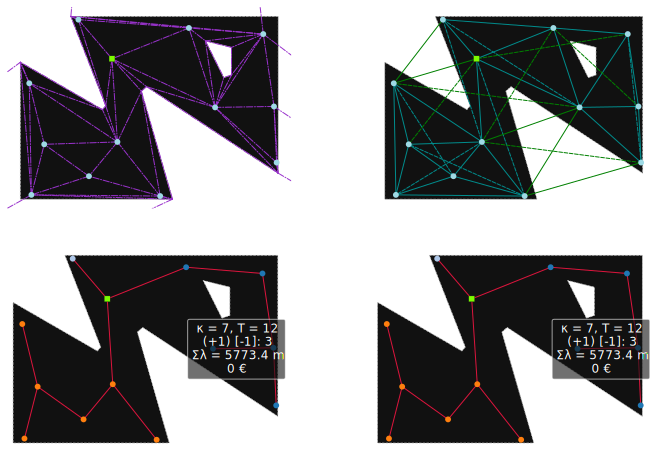

In [5]:
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn1.plot_navigation_mesh(ax=ax1)
wfn1.plot_available_links(ax=ax2)
wfn1.plot_selected_links(ax=ax3)
wfn1.plot(ax=ax4)

### 2. Initialize wfn without obstacles (Only borders):

[[ 696. 1063.]]


<Axes: >

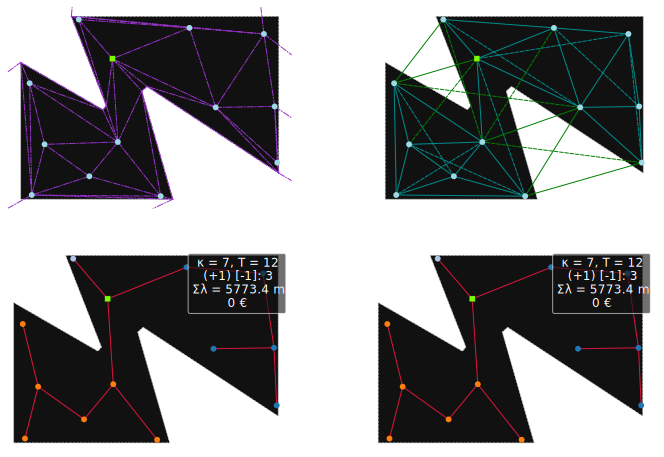

In [6]:
wfn2 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC)
res_optimize = wfn2.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn2.plot_navigation_mesh(ax=ax1)
wfn2.plot_available_links(ax=ax2)
wfn2.plot_selected_links(ax=ax3)
wfn2.plot(ax=ax4)

### 3. Initialize wfn without exterior borders (Only obstacles)

[[ 696. 1063.]]


<Axes: >

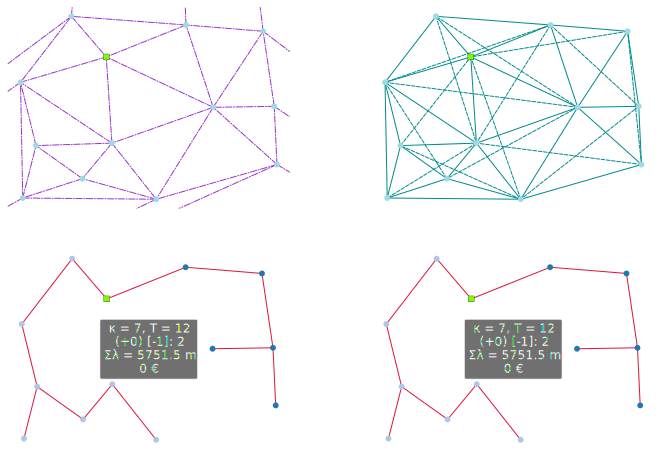

In [7]:
wfn3 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, obstaclesC=obstaclesC)
res_optimize = wfn3.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn3.plot_navigation_mesh(ax=ax1)
wfn3.plot_available_links(ax=ax2)
wfn3.plot_selected_links(ax=ax3)
wfn3.plot(ax=ax4)

### 4. Initialize wfn without borders and obstacles (No borders, no obstacles)

[[ 696. 1063.]]


<Axes: >

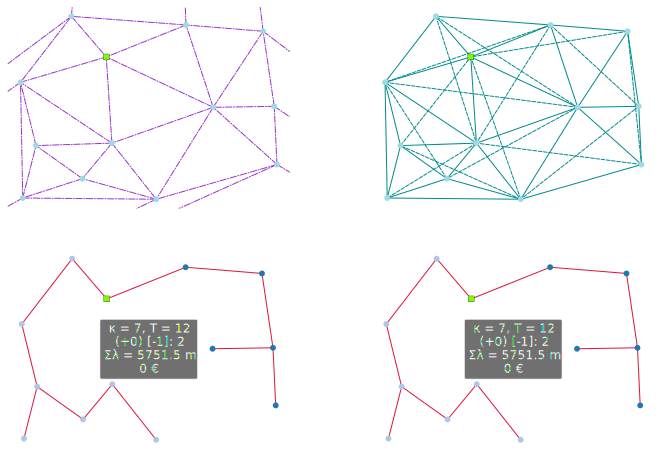

In [8]:
wfn4 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7)
res_optimize = wfn4.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn4.plot_navigation_mesh(ax=ax1)
wfn4.plot_available_links(ax=ax2)
wfn4.plot_selected_links(ax=ax3)
wfn4.plot(ax=ax4)

### 5. New obstacles (intersecting with the exterior borders)

In this case a `Warning` is printed out, providing information about the correspondant obstacle.

In [9]:
obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
    np.array([[-100, 100], [400, 100], [400, 400], [100, 400]]),
]

[[ 696. 1063.]]


<Axes: >

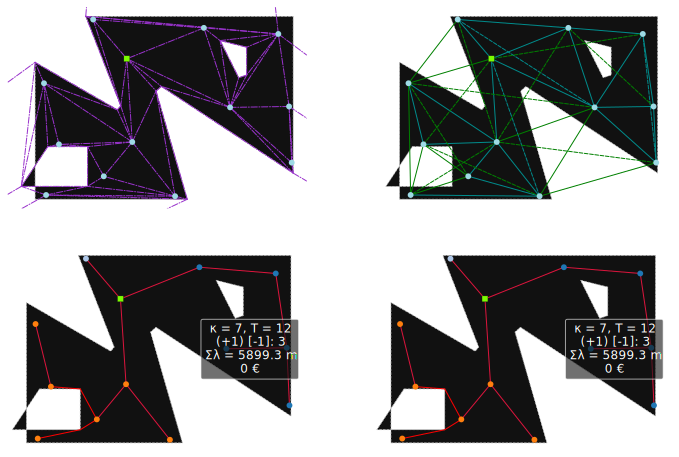

In [10]:
# border + obstacles
wfn5 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC)
res_optimize = wfn5.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn5.plot_navigation_mesh(ax=ax1)
wfn5.plot_available_links(ax=ax2)
wfn5.plot_selected_links(ax=ax3)
wfn5.plot(ax=ax4)

### 6. New obstacles without borders

[[ 696. 1063.]]


<Axes: >

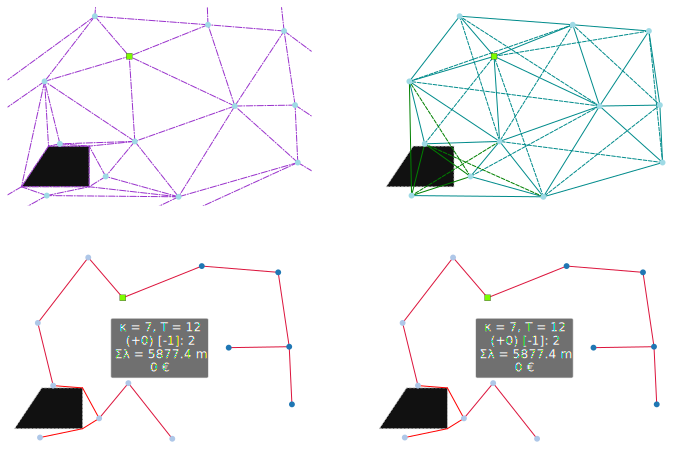

In [11]:
# only obstacles
wfn6 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, obstaclesC=obstaclesC)
res_optimize = wfn6.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn6.plot_navigation_mesh(ax=ax1)
wfn6.plot_available_links(ax=ax2)
wfn6.plot_selected_links(ax=ax3)
wfn6.plot(ax=ax4)

### 7. Obstacle outside the borders
In this case a `Warning` is printed out, providing information about the correspondant obstacle.

[[ 696. 1063.]]


<Axes: >

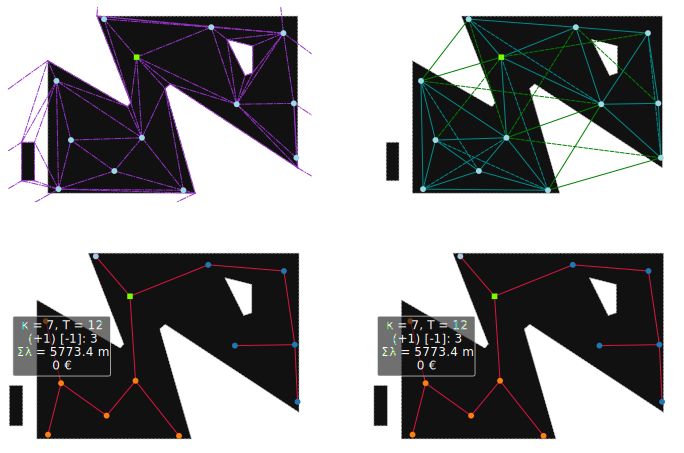

In [12]:
obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
    np.array([[-200, 100], [-100, 100], [-100, 400], [-200, 400]]),
]

substationsC = np.array([[696, 1063],], dtype=float)
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)

wfn7 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC)
res_optimize = wfn7.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn7.plot_navigation_mesh(ax=ax1)
wfn7.plot_available_links(ax=ax2)
wfn7.plot_selected_links(ax=ax3)
wfn7.plot(ax=ax4)

## Buffering
A buffer can be specified when initializing the WindFarmNetwork. The exterior border will be expanded, while interior obstacles will be shrunk accordingly.

### 8. Initialize `WindFarmNetwork`object with a `buffer_dist`.

In [13]:
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)

obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
]

substationsC = np.array([[696, 1063],], dtype=float)
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)

[[ 696. 1063.]]


<Axes: >

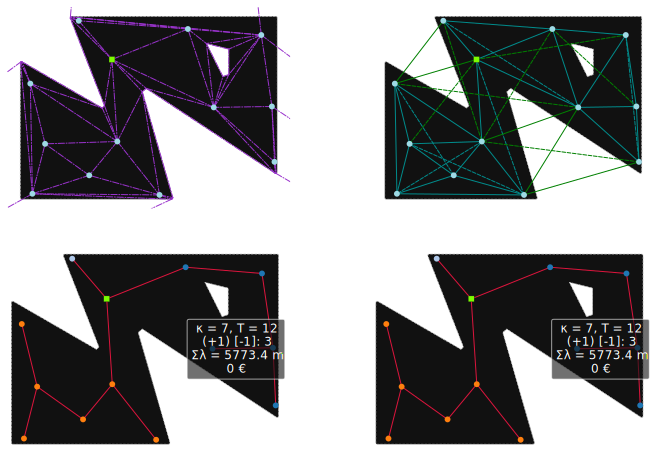

In [14]:
buffer_dist = 10
wfn8 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC, buffer_dist=buffer_dist)
res_optimize = wfn8.optimize()
fig, axs = plt.subplots(2, 2, facecolor='none', figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
wfn8.plot_navigation_mesh(ax=ax1)
wfn8.plot_available_links(ax=ax2)
wfn8.plot_selected_links(ax=ax3)
wfn8.plot(ax=ax4)

Original vs buffered border/obstacles can be visualized using plot_original_vs_buffered()

<Axes: title={'center': 'Original and Buffered Shapes'}>

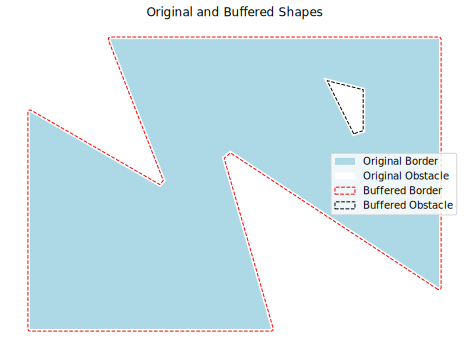

In [15]:
wfn8.plot_original_vs_buffered()

### 9. Removal of a concavity
In this case a `Warning` is printed out, providing information about the unexpected changes in the border.

In [16]:
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)

obstaclesC = [
    np.array([[1400, 1200], [1440, 1200], [1440, 1500], [1400, 1500]]),
    np.array([[1800, 1300], [2000, 1300], [2000, 1301], [1800, 1301]]),
]

buffer_dist = 1
wfn9 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC, buffer_dist=buffer_dist)

Buffering by 1.00 completely removed the obstacle at index 1. For visual comparison use plot_original_vs_buffered().


[[ 696. 1063.]]


Plotting original vs buffered borders confirms that one of the concavities is removed after buffering (upper left side of the border.)

<Axes: title={'center': 'Original and Buffered Shapes'}>

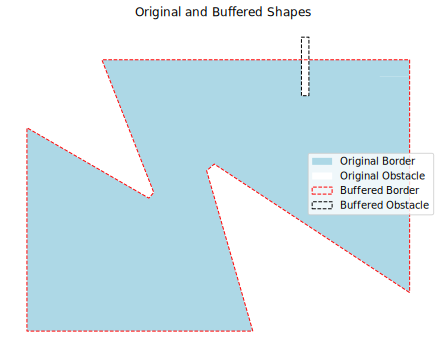

In [17]:
wfn9.plot_original_vs_buffered()

### 10. Removal of an obstacle

In [18]:
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)

obstaclesC = [
    np.array([[1540, 920], [1541, 920], [1541, 1100], [1540, 1100]]),
    np.array([[1300, 920], [1320, 920], [1320, 1100], [1300, 1100]]),
    np.array([[1200, 920], [1205, 920], [1205, 1100], [1200, 1100]]),
]

buffer_dist = 1
wfn10 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC, buffer_dist=buffer_dist)

Buffering by 1.00 completely removed the obstacle at index 0. For visual comparison use plot_original_vs_buffered().


[[ 696. 1063.]]


Plotting original vs buffered borders confirms that abostacle at index 0 is removed after buffering.

<Axes: title={'center': 'Original and Buffered Shapes'}>

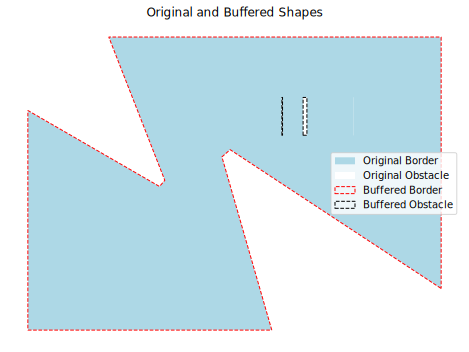

In [19]:
wfn10.plot_original_vs_buffered()

### 11. Split of an obstacle.

In [20]:
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)


obstaclesC = [
    np.array([[1536, 920], [1580, 920], [1580, 1000], [1540, 1000], [1540, 1010], [1580, 1010], [1580, 1100], [1536, 1100]]),
    np.array([[1300, 920], [1320, 920], [1320, 1100], [1300, 1100]]),
    np.array([[1200, 920], [1205, 920], [1205, 1100], [1200, 1100]]),
]

buffer_dist = 2
wfn11 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC, buffer_dist=buffer_dist)

Shrinking by 2.00 split the obstacle at index 0 into 2 pieces. For visual comparison use plot_original_vs_buffered().


[[ 696. 1063.]]


Plotting original vs buffered borders confirms that the obstacle at index 0 is splited into 2 pieces.

<Axes: title={'center': 'Original and Buffered Shapes'}>

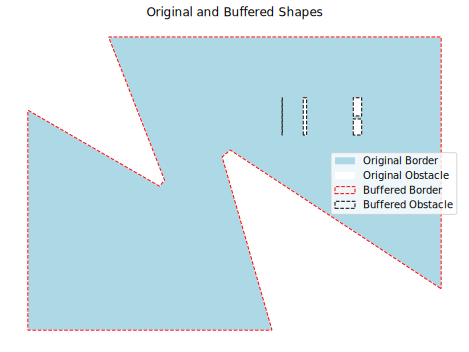

In [21]:
wfn11.plot_original_vs_buffered()

### 12. Removal of an obstacle + split of another obtacle

In [22]:
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)


obstaclesC = [
    np.array([[1535, 920], [1580, 920], [1580, 1000], [1540, 1000], [1540, 1010], [1580, 1010], [1580, 1100], [1535, 1100]]),
    np.array([[1300, 920], [1320, 920], [1320, 1100], [1300, 1100]]),
    np.array([[1200, 920], [1205, 920], [1205, 1100], [1200, 1100]]),
]

buffer_dist = 5
wfn12 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC, buffer_dist=buffer_dist)

Shrinking by 5.00 split the obstacle at index 0 into 2 pieces. For visual comparison use plot_original_vs_buffered().
Buffering by 5.00 completely removed the obstacle at index 2. For visual comparison use plot_original_vs_buffered().


[[ 696. 1063.]]


Plotting original vs buffered borders confirms that the obstacle at index 0 is splited into 2 pieces, and the obstacle at index 2 is removed.

<Axes: title={'center': 'Original and Buffered Shapes'}>

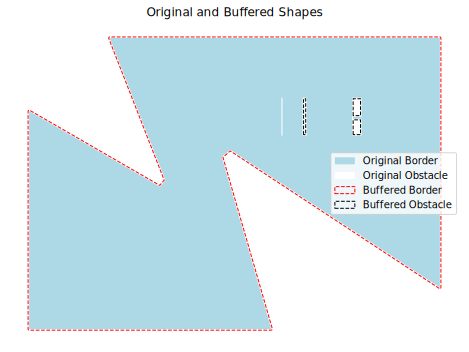

In [23]:
wfn12.plot_original_vs_buffered()

### Turbines outside the border or inside the obstacles

`OptiWindNet` checks if the turbinesC are defined properly with respect to the given border and obstacles.

### 13. Turbines out of the borders

In [24]:
obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
]

substationsC = np.array([[696, 1063],], dtype=float)
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878],  [2000, 2000]],
    dtype=float
)

wfn13 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC)

[[ 696. 1063.]]


### 14. Turbines inside the obstacles

In [25]:
obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
]

substationsC = np.array([[696, 1063],], dtype=float)
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878],  [1550, 1000]],
    dtype=float
)

wfn14 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC)

[[ 696. 1063.]]
